In [ ]:
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
from pprint import pprint

from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/МФТИ/ВКРС/data/data.csv')
df.tail()

,chat_id,chat_type,type,from,client_id,events_count,text,chat.last_message.from,chat.last_message.type,chat.last_message.text,chat.proactive_message.text,latest_chat_id,created_date
8195,21,incoming,message,client,21,4,Здравствуйте!,agent,message,🐳,NaN,21,2021-07-09 07:23:33
8196,21,incoming,message,client,21,4,qwerty,agent,message,🐳,NaN,21,2021-07-09 07:24:12
8197,21,incoming,message,client,21,4,🦄,agent,message,🐳,NaN,21,2021-07-09 07:24:39
8198,21,incoming,message,agent,21,4,🐳,agent,message,🐳,NaN,21,2021-07-09 09:01:25
8199,21,incoming,left,agent,21,4,NaN,agent,message,🐳,NaN,21,2021-07-09 09:35:21


Время ответа оператора (на первое сообщение)

In [ ]:
# Преобразование столбца 'Timestamp' к типу datetime
df['created_date'] = pd.to_datetime(df['created_date'])

# Сортировка данных по идентификатору чата и времени
df = df.sort_values(by=['chat_id', 'created_date'])

# Группировка данных по идентификатору чата
grouped = df.groupby('chat_id')

# Итерация по каждой группе (чату)
for group_name, group_data in grouped:
    # Находим индекс первого сообщения пользователя в чате
    client_message_index = group_data[group_data['from'] == 'client'].index.min()

    # Находим ближайшее сообщение оператора после первого сообщения пользователя
    agent_response_index = group_data[(group_data.index > client_message_index) & (group_data['from'] == 'agent')].index.min()

    # Если найдено сообщение оператора, вычисляем время ответа и записываем его в соответствующий столбец
    if not pd.isnull(agent_response_index):
        response_time = group_data.loc[agent_response_index, 'created_date'] - group_data.loc[client_message_index, 'created_date']
        df.loc[client_message_index, 'first_agent_response_time'] = response_time


In [ ]:
df.describe()

,chat_id,client_id,events_count,latest_chat_id,created_date,first_agent_response_time
count,8200.000000,8200.000000,8200.000000,8200.000000,8200,860
mean,635.285000,269.843171,17.589390,703.382927,2022-12-19 15:32:53.544878080,0 days 03:27:09.882558139
min,11.000000,11.000000,1.000000,21.000000,2021-07-08 12:52:49,0 days 00:00:06
25%,420.000000,156.000000,4.000000,498.000000,2022-07-24 12:57:08,0 days 00:01:14
50%,639.000000,257.000000,7.000000,700.000000,2022-12-16 07:08:23.500000,0 days 00:04:11.500000
75%,860.250000,415.250000,18.000000,991.000000,2023-05-26 16:27:54.249999872,0 days 00:45:22
max,1096.000000,543.000000,74.000000,1096.000000,2023-11-01 12:17:00,3 days 13:25:40
std,259.234265,149.340685,22.919147,265.674081,NaN,0 days 10:32:19.801595364


In [ ]:
df['first_agent_response_time'].describe()

count                          860
mean     0 days 03:27:09.882558139
std      0 days 10:32:19.801595364
min                0 days 00:00:06
25%                0 days 00:01:14
50%         0 days 00:04:11.500000
75%                0 days 00:45:22
max                3 days 13:25:40
Name: first_agent_response_time, dtype: object

In [ ]:
# Преобразование времени в секунды
df['first_agent_response_time_sec'] = df['first_agent_response_time'].dt.seconds
statistics_first_agent_response_time = df['first_agent_response_time_sec'].describe()
#statistics_first_agent_response_time.index = ['Количество', 'Среднее значение', 'Стандартное отклонение', 'Минимальное значение', , , , 'Максимальное значение']
statistics_first_agent_response_time

count      860.000000
mean      6602.905814
std      15407.096098
min          6.000000
25%         74.000000
50%        251.000000
75%       2619.500000
max      83505.000000
Name: first_agent_response_time_sec, dtype: float64

<ipython-input-33-037cc0555456>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['На первое сообщение', 'На все сообщения'])


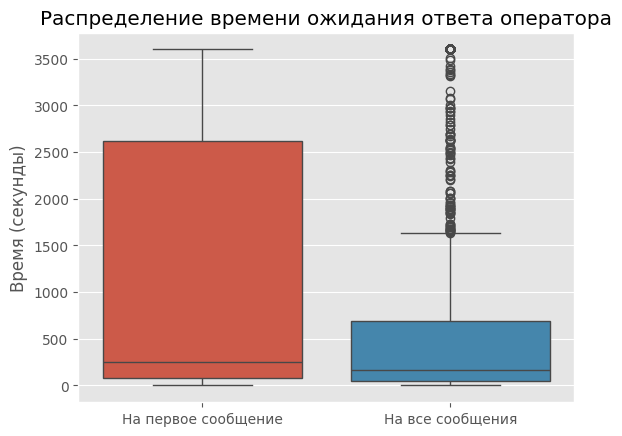

In [ ]:
# Замена значений, превышающих 3600, на 3600
df[['first_agent_response_time_sec', 'response_time_sec']] = df[['first_agent_response_time_sec', 'response_time_sec']].clip(upper=3600)

# Построение boxplot для времени ожидания ответа оператора и времени реакции на сообщение пользователя
ax = sns.boxplot(data=df[['first_agent_response_time_sec', 'response_time_sec']])

# Настройка заголовка и подписей осей
plt.title('Распределение времени ожидания ответа оператора')
plt.ylabel('Время (секунды)')
ax.set_xticklabels(['На первое сообщение', 'На все сообщения'])
# Отображение графика
plt.show()

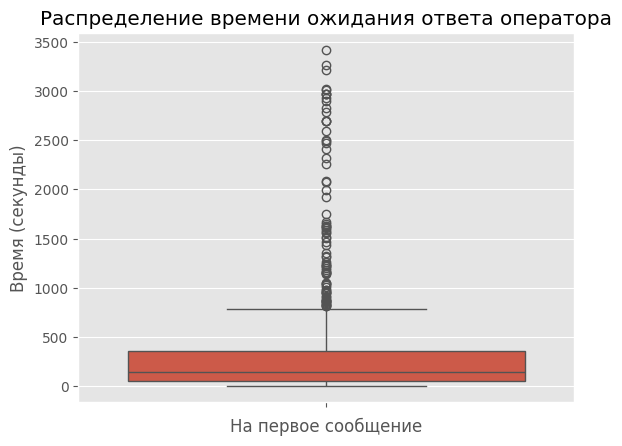

In [ ]:
# Построение boxplot для времени ожидания ответа оператора и времени реакции на сообщение пользователя
sns.boxplot(data=df['first_agent_response_time_sec'][df['first_agent_response_time_sec'] <= 3600])

# Настройка заголовка и подписей осей
plt.title('Распределение времени ожидания ответа оператора')
plt.ylabel('Время (секунды)')
plt.xlabel('На первое сообщение')
#ax.set_xticklabels(['На первое сообщение', 'На все сообщения'])
# Отображение графика
plt.show()

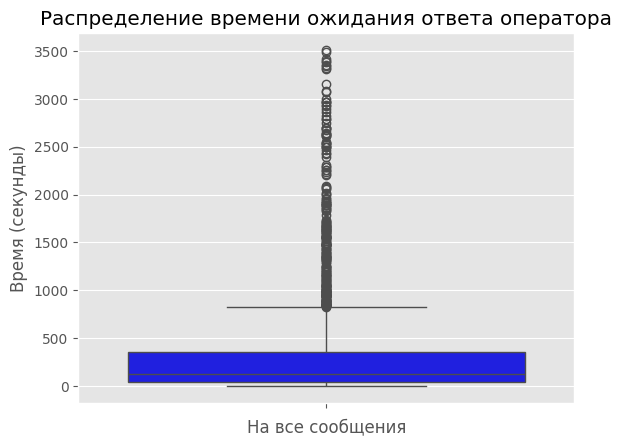

In [ ]:
# Построение boxplot для времени ожидания ответа оператора и времени реакции на сообщение пользователя
sns.boxplot(data=df['response_time_sec'][df['response_time_sec'] <= 3600], color='blue')

# Настройка заголовка и подписей осей
plt.title('Распределение времени ожидания ответа оператора')
plt.ylabel('Время (секунды)')
plt.xlabel('На все сообщения')
#ax.set_xticklabels(['На первое сообщение', 'На все сообщения'])
# Отображение графика
plt.show()

Время ответа оператора (все сообщения)

In [ ]:
# Создаем столбец 'response_time', в котором будет храниться время ответа оператора на сообщение пользователя
df['response_time'] = pd.NaT

# Группируем данные по chat_id и проходим по каждой группе
for chat_id, group in df.groupby('chat_id'):
    last_client_time = None
    agent_responded = False

    # Проходим по каждой строке в группе
    for index, row in group.iterrows():
        # Если сообщение от пользователя
        if row['from'] == 'client':
            last_client_time = row['created_date']
            agent_responded = False
        # Если сообщение от оператора и предыдущее сообщение было от пользователя
        elif not agent_responded and last_client_time is not None:
            # Вычисляем время ответа оператора на последнее сообщение пользователя
            response_time = row['created_date'] - last_client_time
            df.at[index, 'response_time'] = response_time
            agent_responded = True

In [ ]:
df[['chat_id', 'from', 'first_agent_response_time', 'response_time']].tail(20)

,chat_id,from,first_agent_response_time,response_time
91,1091,client,NaT,NaT
92,1091,agent,NaT,0 days 00:00:38
93,1091,agent,NaT,NaT
94,1092,client,1 days 03:28:31,NaT
95,1092,client,NaT,NaT
96,1092,agent,NaT,1 days 03:27:59
70,1093,client,0 days 04:00:49,NaT
71,1093,client,NaT,NaT
72,1093,agent,NaT,0 days 03:59:56
73,1093,client,NaT,NaT


In [ ]:
df['response_time'] = pd.to_timedelta(df['response_time'])

In [ ]:
# Преобразование времени в секунды
df['response_time_sec'] = df['response_time'].dt.seconds
statistics_response_time = df['response_time_sec'].describe()
statistics_response_time

count     2208.000000
mean      3083.245018
std      10268.018332
min          0.000000
25%         51.000000
50%        160.000000
75%        684.750000
max      84668.000000
Name: response_time_sec, dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8200 entries, 8181 to 3
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype          
---  ------                         --------------  -----          
 0   chat_id                        8200 non-null   int64          
 1   chat_type                      8200 non-null   object         
 2   type                           8200 non-null   object         
 3   from                           8200 non-null   object         
 4   client_id                      8200 non-null   int64          
 5   events_count                   8200 non-null   int64          
 6   text                           7103 non-null   object         
 7   chat.last_message.from         8200 non-null   object         
 8   chat.last_message.type         8200 non-null   object         
 9   chat.last_message.text         8200 non-null   object         
 10  chat.proactive_message.text    1022 non-null   object         
 11  latest_ch

In [ ]:
# Извлечем информацию о времени дня или дня недели
df['hour'] = df['created_date'].dt.hour  # Время дня (час)
df['weekday'] = df['created_date'].dt.weekday  # День недели (0 - Понедельник, ..., 6 - Воскресенье)

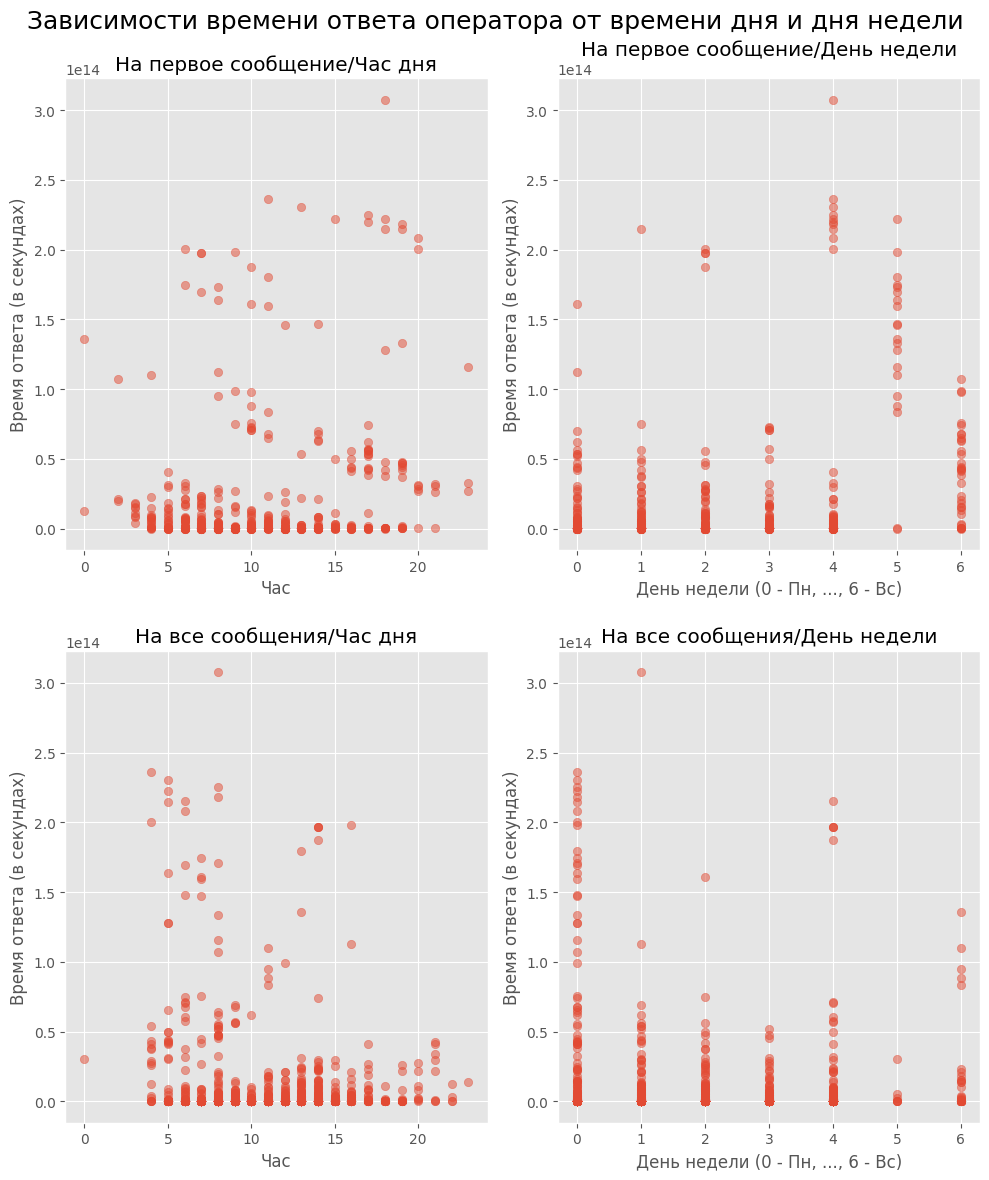

In [ ]:
plt.style.use('ggplot')
# Построим графики
plt.figure(figsize=(10, 12))

plt.suptitle('Зависимости времени ответа оператора от времени дня и дня недели', fontsize=18) # Установка названия для всего поля

# Зависимость времени ответа оператора на первое сообщение пользователя от времени дня
plt.subplot(2, 2, 1)
plt.scatter(df['hour'], df['first_agent_response_time'], alpha=0.5)
plt.title('На первое сообщение/Час дня')
plt.xlabel('Час')
plt.ylabel('Время ответа (в секундах)')

# Зависимость времени ответа оператора на первое сообщение пользователя от дня недели
plt.subplot(2, 2, 2)
plt.scatter(df['weekday'], df['first_agent_response_time'], alpha=0.5)
plt.title('На первое сообщение/День недели')
plt.xlabel('День недели (0 - Пн, ..., 6 - Вс)')
plt.ylabel('Время ответа (в секундах)')

# Зависимость времени ответа оператора (вообще, не только на первое сообщение) от времени дня
plt.subplot(2, 2, 3)
plt.scatter(df['hour'], df['response_time'], alpha=0.5)
plt.title('На все сообщения/Час дня')
plt.xlabel('Час')
plt.ylabel('Время ответа (в секундах)')

# Зависимость времени ответа оператора (вообще, не только на первое сообщение) от дня недели
plt.subplot(2, 2, 4)
plt.scatter(df['weekday'], df['response_time'], alpha=0.5)
plt.title('На все сообщения/День недели')
plt.xlabel('День недели (0 - Пн, ..., 6 - Вс)')
plt.ylabel('Время ответа (в секундах)')

plt.tight_layout()
plt.show()

На четвертом графике четко видно хаотичное распределение времени ответа оператора по понедельникам